In [1]:
import sumie
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import skimage
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [29]:
model = torchvision.models.resnet50(pretrained=True).eval()
sumie.utils.remove_inplace(model)
#sumie.utils.max_to_avg_pool(model)
#model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
#model = torch.nn.Sequential(*list(model.children()))
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/justin/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 82164042.16it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        

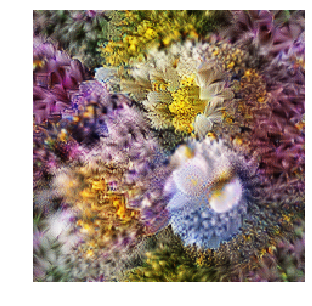

In [34]:
def normalise(image):
    
        mean = torch.as_tensor([0.485, 0.456, 0.406])
        std = torch.as_tensor([0.229, 0.224, 0.225])
        return (image - mean[None,:,None,None]) /std[None,:,None,None]
 
class Direction():
    
    def __init__(self, module, target):
        self.monitor = sumie.objectives.ModuleMonitor(module)
        self.target = target.detach()
        
    @property
    def objective(self):
        if self.monitor.values is not None:
            #picked_value = self.monitor.values[0,:,2,2]
            picked_value = torch.mean(self.monitor.values, (2, 3)).squeeze(0)
            return direction_func(picked_value, 
                                  torch.mean(self.target, (2, 3)).squeeze(0))

    
def direction_func(x, y):
    cossim_pow = 2
    eps = 1e-4
    xy_dot = torch.dot(x, y)
    x_mag = torch.sqrt(torch.dot(x, x))
    y_mag = torch.sqrt(torch.dot(y, y))
    cossims = xy_dot / (eps + x_mag) / (eps + y_mag)
    #floored_cossims = torch.max(torch.Tensor((0.1,)), cossims)
    return torch.mean(xy_dot * cossims**cossim_pow)

#url = 'https://upload.wikimedia.org/wikipedia/commons/e/eb/Ash_Tree_-_geograph.org.uk_-_590710.jpg'
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Chrysanthemum_February_2008-1.jpg/299px-Chrysanthemum_February_2008-1.jpg'
imsize = 224

device = 'cuda'
model.to(device)
base_image = sumie.io.load_url(url, size=(imsize, imsize))
base_image = normalise(base_image)
n_sections = 1
layer = 6
n_layers = 1
selected_module = model.layer4[1].conv3

for n in range(layer,layer+n_layers):
    monitor = sumie.objectives.ModuleMonitor(selected_module)
    model(base_image.to(device))
    target = monitor.values
    size = target.shape
    for x in range(n_sections):
        for y in range(n_sections):
            if n_sections > 1:
                new_target = target[:,:,
                                    math.floor(x*(size[2]-1)/(n_sections-1)),
                                    math.floor(y*(size[3]-1)/(n_sections-1))]
                new_target = new_target[:,:,None,None]
            else:
                new_target = target

            im = sumie.Image(imsize, param='fft', transforms=[
                                sumie.transforms.PositionJitter(16),
                                #sumie.transforms.Interpolate(0.5),
                                #sumie.transforms.ScaleJitter(1.02),
                                sumie.transforms.RotationJitter(0.1),
                                sumie.transforms.PositionJitter(8),
                                sumie.transforms.Normalise(),
                          ])

            im.to(device)
            direction = Direction(selected_module, new_target.detach())

            
            opt = sumie.Optimiser(im, model, direction)
            opt.run(iterations=256, lr=0.05)
            sumie.vis.show(im.get_image())
            sumie.io.save(im.get_image(), f'tmp/{n:03}_{x:03}_{y:03}.jpg')

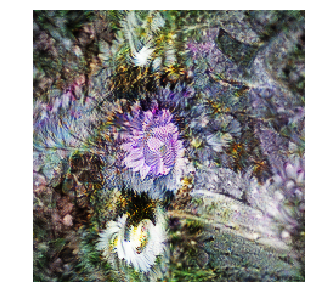

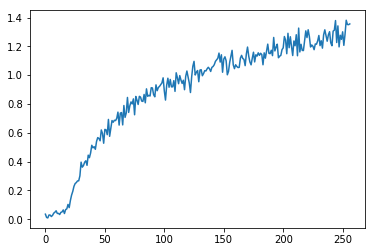

In [33]:
sumie.vis.show(im.get_image())
plt.plot([x.item() for x in opt.history])

In [ ]:
opt.image.transforms[1].factor = 0.5
opt.run(iterations=256, lr=0.05, progress=True)
sumie.vis.show(im.get_image(), figsize=(10,10))

In [ ]:
opt.image.transforms[1].factor = 1
opt.run(iterations=256, lr=0.05, progress=True)
sumie.vis.show(im.get_image(), figsize=(10,10))